In [158]:
from pyspedas import noaa_load_kp
import pandas as pd
from pyspedas import tplot, tplot_save

In [159]:
import logging
import numpy as np
from pytplot import (
    time_string,
    time_double,
)
from pyspedas.projects.noaa.config import CONFIG
from pyspedas.utilities.dailynames import dailynames
from pyspedas.utilities.download import download


def kp_return_fraction(value):
    value = np.array(value, dtype=np.float64)
    kp_lhs = value // 10
    kp_rhs_times_3 = value % 10
    kp_rhs = kp_rhs_times_3 // 3.0
    return kp_lhs + kp_rhs / 3.0


def convert_to_float_or_int(a, outtype="int"):
    ans = []
    for v in a:
        try:
            if outtype == "float":
                ans.append(float(v))
            else:  # outtype == "int"
                ans.append(int(v))
        except ValueError:
            ans.append(0)
    return ans


def load_kp_to_df(
    trange,
    files=[],
    datatype=[],
):
    vars = []

    if files is None or len(files) == 0:
        logging.error("No files specified")
        return vars
    elif not isinstance(files, list):
        files = [files]

    if datatype is None or datatype == [] or len(datatype) == 0:
        datatype = [
            "Kp",
        ]
    elif not isinstance(datatype, list):
        datatype = [datatype]
    datatype = [d.lower() for d in datatype]

    # Each line in the files contains data for one day.
    # The first 3 quantities are measured every 3 hours (8 measurements per day).
    kpdata = []
    kptimes = []
    daytimes = []

    for kpfile in files:
        # Example line contained in these files:
        # 1701012502 73337272323302017210 18 22 12  9  9 15  7  6 120.73---070.10
        # Line length is 73 for NOAA files and 63 for WDC files (both counts include \n).

        with open(kpfile, "r") as f:
            for line in f:
                if len(line) < 63 or line.startswith("#") or line.startswith(" "):
                    # Skip lines that are less than 63 characters long (62 data and \n)
                    continue

                # Get datetimes (0:6 characters)
                year = line[0:2]
                if "00" <= year <= "69":
                    year = "20" + year
                else:
                    year = "19" + year
                month = line[2:4]
                day = line[4:6]
                ymd = year + "-" + month + "-" + day
                daytimes.append(time_double(ymd))
                for k in range(8):
                    dd = time_double(ymd + " " + "{:02d}".format(k * 3) + ":00:00")
                    kptimes.append(dd)
                for k in range(8):
                    kpdata.append(line[12 + 2 * k : 14 + 2 * k])

    # Check for empty data set. If empty, return.
    if len(kptimes) == 0:
        logging.error("No data found.")
        return vars
    if (
        len(trange) == 2
        and trange[0] != 0
        and time_double(trange[1]) > time_double(trange[0])
        and (
            time_double(trange[1]) < kptimes[0] or time_double(trange[0]) > kptimes[-1]
        )
    ):
        logging.error("No data found in time range.")
        return vars
    
    vars = pd.DataFrame({'DateTime': kptimes, 'KP': kp_return_fraction(kpdata)})
    vars['DateTime'] = pd.to_datetime(vars['DateTime'], unit='s')
    
    return vars


def noaa_load_kp(
    trange
):
    vars = []

    if len(trange) == 2:
        trangestr = time_string(time_double(trange))
        start_year = int(trangestr[0][0:4])
        end_year = int(trangestr[1][0:4])
    else:
        logging.error("Invalid time range")
        return
    if end_year > start_year + 3:  # Limit to 4 years
        end_year = start_year + 3
        trange[1] = str(end_year) + "-12-31/00:00:00"
        logging.warning(
            "Time limit is 4 years, new time range is " + trange[0] + " to " + trange[1]
        )
    elif end_year < start_year:
        end_year = start_year
        trange[1] = str(end_year) + "-12-31/00:00:00"
        logging.warning(
            "End time is before start time, new time range is "
            + trange[0]
            + " to "
            + trange[1]
        )

    # Remote site and directory
    
    remote_data_dir = CONFIG['gfz_remote_data_dir']
    pathformat = "Kp_def%Y.wdc"
    
    logging.info("Loading geomagnetic index data from " + remote_data_dir)
    remote_names = dailynames(file_format=pathformat, trange=trange)
    files = download(
        remote_file=remote_names,
        remote_path=remote_data_dir,
    )

    if len(files) == 0:
        logging.error("No files found.")
        return vars

    vars = load_kp_to_df(
        trange=trange,
        files=list(set(files)),
    )

    return vars

17-May-25 18:03:55: Loading geomagnetic index data from https://datapub.gfz-potsdam.de/download/10.5880.Kp.0001/Kp_definitive/
17-May-25 18:03:55: File is current: /Users/soumya/Desktop/cassini_hack/Kp_def2015.wdc


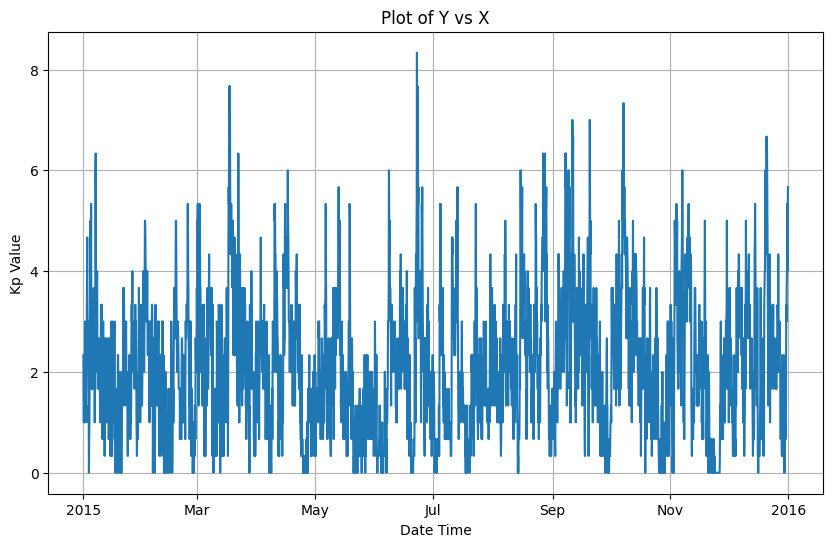

In [165]:
import matplotlib.pyplot as plt
df = noaa_load_kp(trange=["2015-03-01/00:00:00", "2015-03-01/23:59:59"])

# print(df.head(10))
plt.figure(figsize=(10, 6))
plt.plot(df['DateTime'], df['KP'])
plt.title('Plot of Y vs X')
plt.xlabel('Date Time')
plt.ylabel('Kp Value')
plt.grid(True)
plt.show()
